# 계정 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 전처리 (spaCy)

In [2]:
!pip install spacy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import json
import sklearn

from sklearn.model_selection import train_test_split

In [4]:
data_df = pd.read_csv("/content/drive/MyDrive/application_data.csv")

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48767 entries, 0 to 48766
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   contents  48759 non-null  object
 1   star      48767 non-null  int64 
 2   agree     48767 non-null  int64 
 3   date      48767 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [6]:
data_df = pd.read_csv("/content/drive/MyDrive/application_data.csv")
data_df.head(3)

,contents,star,agree,date
0,"The game used to work well, was fun to play. T...",1,43,2025-03-01 13:28:57
1,App will open your browser and several tabs wi...,2,250,2025-01-09 00:38:29
2,I enjoy this game and would give it more stars...,3,12,2025-03-05 22:23:06


<Axes: xlabel='star', ylabel='count'>

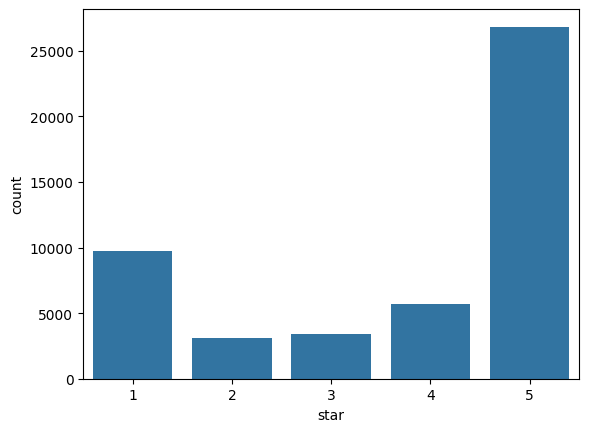

In [7]:
sns.countplot(x='star', data=data_df)

# 별점을 통해서 레이블링 작업을 수행

 (4, 5점은 긍정 // 1, 2점은 부정 // 3점은 중립으로 제외)

In [8]:
# 중립 제거
df_except_neut = data_df['star'] != 3
data_df = data_df[df_except_neut]

# 레이블링 할당 (긍정 : 1, 부정 : 0)
data_df['sentiment'] = [1 if i > 3 else 0 for i in data_df['star']]

# nan 값 제거
data_df = data_df.dropna()

# 중복 제거
data_df = data_df.drop_duplicates()

data_df.reset_index(drop=True, inplace=True)

data_df

<ipython-input-8-9d441f06bbc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['sentiment'] = [1 if i > 3 else 0 for i in data_df['star']]


,contents,star,agree,date,sentiment
0,"The game used to work well, was fun to play. T...",1,43,2025-03-01 13:28:57,0
1,App will open your browser and several tabs wi...,2,250,2025-01-09 00:38:29,0
2,"This game works against you, it gives you tile...",1,3,2025-03-08 03:00:04,0
3,UPDATE 3-1-2025 i really loved this puzzle gam...,1,38,2025-03-02 01:38:32,0
4,This game lags to much to where you just can't...,1,40,2025-02-21 17:55:12,0
...,...,...,...,...,...
45318,🗑,1,0,2021-04-03 20:47:05,0
45319,👎,1,0,2023-01-31 16:45:14,0
45320,👎,1,0,2021-09-26 08:07:00,0
45321,👎,1,0,2021-02-17 05:52:33,0


# 클래스의 차이 확인

(긍정 레이블과 부정 레이블의 차이를 확인하자!)

긍정 개수: 32491
부정 개수: 12832


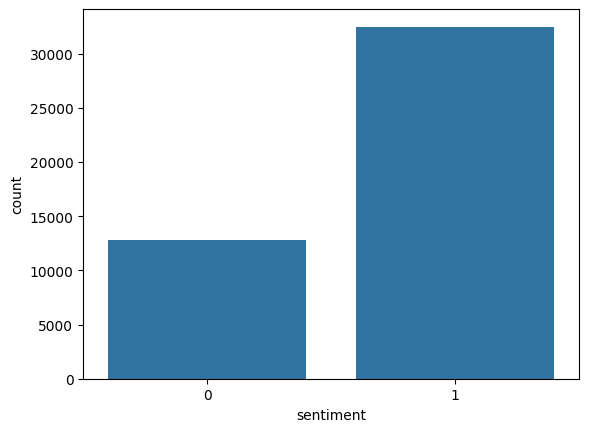

In [9]:
import seaborn as sns

sns.countplot(x='sentiment', data=data_df)
print("긍정 개수:", (data_df["sentiment"] == 1).sum())
print("부정 개수:", (data_df["sentiment"] == 0).sum())

In [10]:
def equal_ratio(df): #downsampling
    # 레이블링 확인
    pos = df['sentiment'] == 1
    neg = df['sentiment'] == 0

    # pos와 neg 구분
    pos = df[pos]
    neg = df[neg]

    # 이전 개수 출력
    print(len(pos),"before pos")
    print(len(neg),"before neg")

    # 비율 맞춤
    pos_len = len(pos)
    neg_len = len(neg)
    max_len = max(pos_len, neg_len)

    DFF = abs(pos_len - neg_len)
    ratio = 1 - (DFF / max_len)

    if pos_len == neg_len:
      pass
    elif pos_len > neg_len:
        pos = pos.sample(frac=ratio, random_state=82)
    else:
        neg = neg.sample(frac=ratio, random_state=82)

    # 이후 개수 출력
    print(len(pos),"after pos")
    print(len(neg),"after neg")

    df = pd.concat([pos, neg], axis=0)
    df = sklearn.utils.shuffle(df, random_state=82).reset_index(drop=True)

    return df

32491 before pos
12832 before neg
12832 after pos
12832 after neg


<Axes: xlabel='sentiment', ylabel='count'>

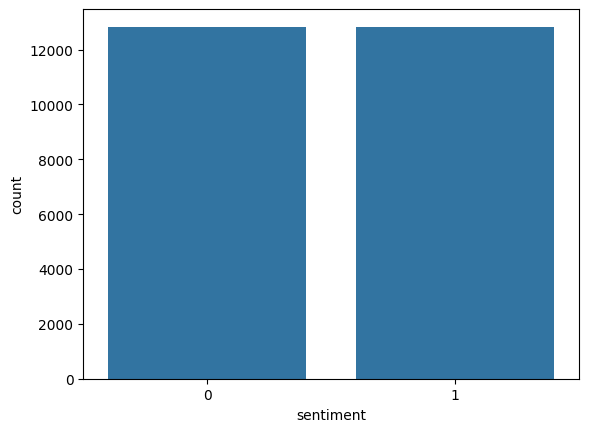

In [11]:
data_df = equal_ratio(data_df)
sns.countplot(x='sentiment', data=data_df)

In [12]:
# spaCy는 파이썬의 자연어처리를 위한 오픈 소스 기반 라이브러리
import spacy
nlp = spacy.load("en_core_web_sm")

In [13]:
# 데이터 정규화 과정 겪은 후에 contents가 길이 0인 것은 제거
def preprocessing(review):
    #re
    review = re.sub("[^a-zA-Z]", " ", review)
    word_li = review.lower().split()
    sentence = ' '.join(word_li)

    # lemmatization (spacy)
    token_li = nlp(sentence)
    word_li = [token.lemma_ for token in token_li if not token.is_stop]

    # 문자열로 변환 (띄어쓰기 한 칸 기준으로)
    sentence = ' '.join(word_li)

    return sentence

In [14]:
from tqdm import tqdm
tqdm.pandas()
data_df["prepro"] = data_df["contents"].progress_apply(preprocessing)

100%|██████████| 25664/25664 [04:06<00:00, 103.96it/s]


# 샘플 데이터

In [15]:
sample_1 = "string is long"
sample_prepro_1 = preprocessing(sample_1)

print(sample_prepro_1)

sample_2 = "is is is "
sample_prepro_2 = preprocessing(sample_2)

print(sample_prepro_2)
print(len(sample_prepro_2))

string long

0


In [16]:
print("공백 제거 전 데이터 개수: ", len(data_df))

not_empty_value = data_df["prepro"] != ""
data_df = data_df[not_empty_value]
print("공백 제거 후 데이터 개수: ", len(data_df))

공백 제거 전 데이터 개수:  25664
공백 제거 후 데이터 개수:  25362


In [17]:
x_feature = data_df["prepro"].copy()
y_label = data_df["sentiment"].copy()

# 훈련 세트 및 테스트 세트 나누기

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_feature, y_label, test_size=0.2, random_state=42)

In [19]:
print(x_train[0:5])
print("*"*20)
print(y_train[0:5])

11329    challenge unfortunately s seize t play hope ge...
10246             game ad ad cut gameplay long finish game
21529                                               update
2280                                      start play enjoy
14977                                       gooooooog game
Name: prepro, dtype: object
********************
11329    1
10246    0
21529    0
2280     1
14977    1
Name: sentiment, dtype: int64


In [20]:
print(x_test[0:5])
print("*"*20)
print(y_test[0:5])

11210                                                  fun
20269    spam spam spam spamitty spam spam play burn da...
8391                                            great game
2283     recent change ruin game removal daily task goo...
17005                                            stimulate
Name: prepro, dtype: object
********************
11210    1
20269    0
8391     1
2283     0
17005    1
Name: sentiment, dtype: int64


# Feature extraction and modeling

##BoW

In [21]:
# BoW embedding
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(analyzer='word', max_features=3000)

# train
x_bow_train = bow_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

# test
x_bow_test = bow_vectorizer.transform(x_test)
y_test = np.array(y_test)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# class_weight='balanced' 통해서 균형있게 학습
lg_bow_model = LogisticRegression(class_weight='balanced')

hyper_parmas = {"max_iter": [1000, 2000, 3000]}

grid_lr_bow_model = GridSearchCV(lg_bow_model, param_grid=hyper_parmas, cv=5, refit=True, return_train_score=True)
grid_lr_bow_model.fit(x_bow_train, y_train)

print(f"모델의 최고 정확도 : {grid_lr_bow_model.best_score_}")

estimator = grid_lr_bow_model.best_estimator_
pred_y_bow = estimator.predict(x_bow_test)

모델의 최고 정확도 : 0.9147321807661232


Text(0.5, 427.9555555555555, 'Predicted label')

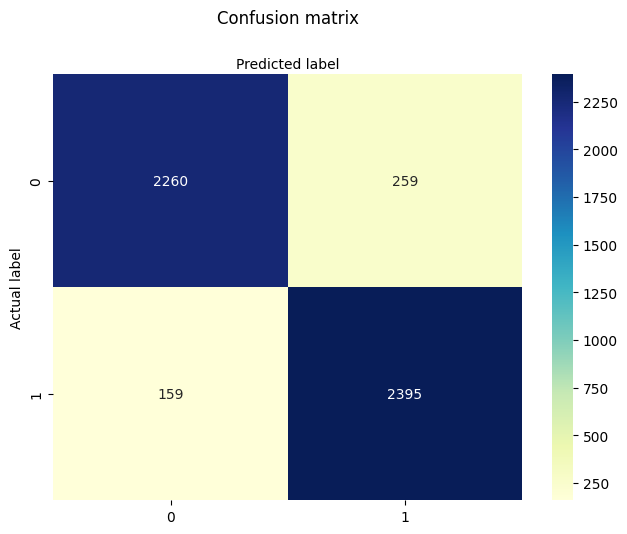

In [23]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_bow)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y_bow, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.93      0.90      0.92      2519
         pos       0.90      0.94      0.92      2554

    accuracy                           0.92      5073
   macro avg       0.92      0.92      0.92      5073
weighted avg       0.92      0.92      0.92      5073



In [25]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_bow))

0.9176029962546817


## TF-IDF

In [26]:
# tfidf embedding
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df = 0.0, analyzer='word', ngram_range=(1,3), max_features=3000)

# train
x_tfidf_train = tfidf_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

# test
x_tfidf_test = tfidf_vectorizer.transform(x_test)
y_test = np.array(y_test)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# class_weight='balanced' 통해서 균형있게 학습
lg_tfidf_model = LogisticRegression(class_weight='balanced')

hyper_parmas = {"max_iter": [1000, 2000, 3000]}

grid_lr_tfidf_model = GridSearchCV(lg_tfidf_model, param_grid=hyper_parmas, cv=5, refit=True, return_train_score=True)
grid_lr_tfidf_model.fit(x_tfidf_train, y_train)

print(f"모델의 최고 정확도 : {grid_lr_tfidf_model.best_score_}")

estimator = grid_lr_tfidf_model.best_estimator_
pred_y_tfidf = estimator.predict(x_tfidf_test)

모델의 최고 정확도 : 0.9215338644619738


Text(0.5, 427.9555555555555, 'Predicted label')

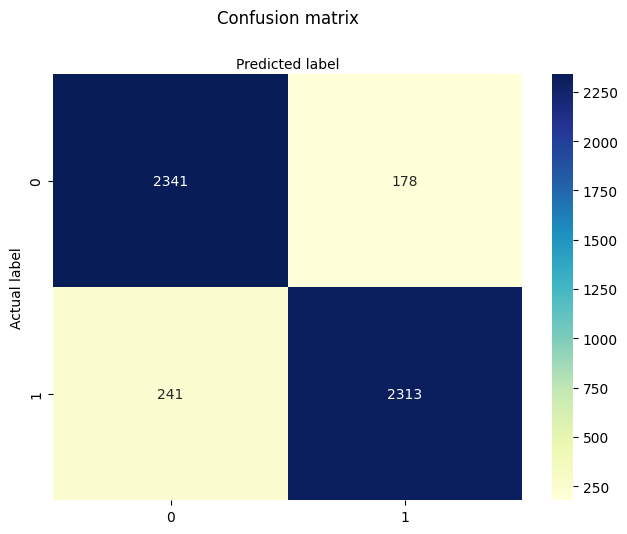

In [28]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_tfidf)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_tfidf, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.91      0.93      0.92      2519
         pos       0.93      0.91      0.92      2554

    accuracy                           0.92      5073
   macro avg       0.92      0.92      0.92      5073
weighted avg       0.92      0.92      0.92      5073



In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_tfidf))

0.9174058742361522


##Word2Vec

In [31]:
# Word2Vec은 단어로 이루어진 리스트를 입력값으로 넣어야 한다.
x_train_li = [sentence.split() for sentence in list(x_train)]
x_test_li = [sentence.split() for sentence in list(x_test)]

In [32]:
!pip install gensim

In [33]:
!pip install --force-reinstall numpy==1.23.5

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but 

In [34]:
from gensim.models import word2vec
model = word2vec.Word2Vec(x_train_li, vector_size=500, min_count=10, window=10)
model.save("./w2v_model")

In [35]:
def w2v_features(words, model, num_features):
  # w2v은 단어 별 벡터의 표현이 나오기 때문에, 문장을 표현해 줄때는, 단어 별 벡터의 합을 개수로 나눠서 표현한다.
  # 미리 정해준 feature 차원으로 np.zeros를 만들어 준다.
  feature_vector = np.zeros((num_features), dtype=np.float32)

  count = 0
  # 어휘사전 준비
  index2word_set = set(model.wv.index_to_key)

  for word in words:
    if word in index2word_set:
      count += 1
      # 사전에 해당하는 단어에 대한 단어 벡터를 더함
      feature_vector = np.add(feature_vector, model.wv[word])

  if count == 0:
    feature_vector = np.zeros((num_features), dtype=np.float32)
  else:
    feature_vector = np.divide(feature_vector, count)

  return feature_vector

In [36]:
def get_features(reviews, model, num_features):
  dataset = [w2v_features(sentence, model, num_features) for sentence in reviews]
  review_features_vecs = np.stack(dataset)

  return review_features_vecs

In [37]:
# train
x_w2v_train = get_features(x_train_li, model, num_features=500)
y_train = np.array(y_train)

# test
x_w2v_test = get_features(x_test_li, model, num_features=500)
y_test = np.array(y_test)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# class_weight='balanced' 통해서 균형있게 학습
lg_w2v_model = LogisticRegression(class_weight='balanced')

hyper_parmas = {"max_iter": [1000, 2000, 3000]}

grid_lr_w2v_model = GridSearchCV(lg_w2v_model, param_grid=hyper_parmas, cv=5, refit=True, return_train_score=True)
grid_lr_w2v_model.fit(x_w2v_train, y_train)

print(f"모델의 최고 정확도 : {grid_lr_w2v_model.best_score_}")

estimator = grid_lr_w2v_model.best_estimator_
pred_y_w2v = estimator.predict(x_w2v_test)

모델의 최고 정확도 : 0.8792448491208266


Text(0.5, 427.9555555555555, 'Predicted label')

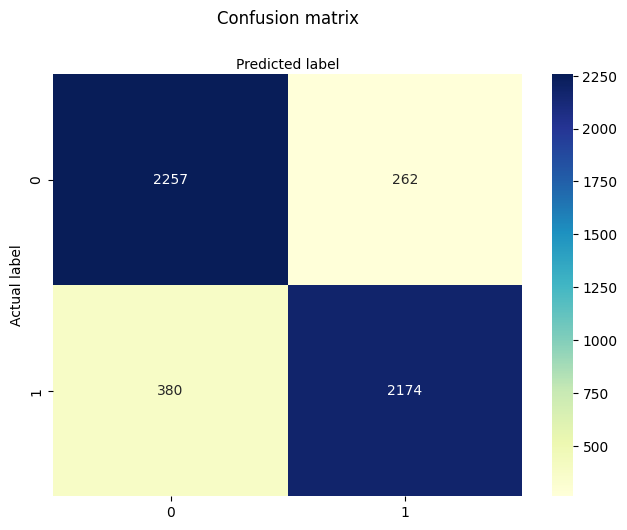

In [39]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_w2v)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_w2v, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.86      0.90      0.88      2519
         pos       0.89      0.85      0.87      2554

    accuracy                           0.87      5073
   macro avg       0.87      0.87      0.87      5073
weighted avg       0.87      0.87      0.87      5073



In [41]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_w2v))

0.8734476641040805


# 결과 저장

In [42]:
result_di = {
    "test_contents": x_test,
    "sentiment": y_test,
    "bow": pred_y_bow,
    "tfidf": pred_y_tfidf,
    "w2v": pred_y_w2v
}
result_df = pd.DataFrame(result_di)
result_df.to_csv("./sentiment classification.csv")